In [1]:
import argparse
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.io as sio
import seaborn as sns
import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR, LinearSVC
from sklearn.metrics import (
    accuracy_score,
    silhouette_score,
    adjusted_rand_score,
    silhouette_samples,
)
from sklearn.cluster import AgglomerativeClustering, SpectralClustering, KMeans
from sklearn.model_selection import KFold, LeaveOneOut, train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.kernel_ridge import KernelRidge
from sklearn import linear_model
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import (
    ModelDesc,
    EvalEnvironment,
    Term,
    EvalFactor,
    LookupFactor,
    dmatrices,
    INTERCEPT,
)
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.colorbar as colorbar
import sys

from s2p_utils.data_loader import DataLoader
from s2p_utils.processing_utils import (
    correct_overlapping_cells_across_planes,
    correct_timestamps,
    get_cell_only_activity,
    extract_events,
    get_corrected_F,
    extract_interest_time_intervals,
    extract_imaging_ts_around_events,
    normalize_signal,
    extract_Fave_around_events,
    reorder_clusters,
)
from plot_utils import (
    plot_raw_licks,
    plot_average_PSTH_around_interest_window,
    plot_individual_cells_activity,
    plot_PC_screenplot,
    plot_PCs,
    make_silhouette_plot,
    plot_activity_clusters,
    plot_cluster_pairs,
)

c:\Users\mzhou9\Anaconda3\envs\py3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
c:\Users\mzhou9\Anaconda3\envs\py3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


In [3]:
# Initialize variables
data_dir = "Z:\\2p\\experiment1\\MZ_hpc_prism_M6\\d7\\"
num_planes = 4
pre_cue_window = 3
post_cue_window = 17
delay_to_reward = 3
trial_types = ["CS1+", "CS2+", "CS3-"]
neucoeff = 0.7
framerate = 

In [4]:
# Get data loader
data_loader = DataLoader(data_dir, num_planes)

# Make a result folder if if didn't exist
result_dir = os.path.join(data_dir, "result")
if not os.path.exists(result_dir):
    os.makedirs(result_dir)
file_dir = os.path.join(data_dir, "files")

In [5]:
# Load data
F = data_loader.get_F()
Fneu = data_loader.get_Fneu()
stat = data_loader.get_stat()
is_cell = data_loader.get_is_cell()
# ops = data_loader.get_ops()
# spks = data_loader.get_spks()
event_df = data_loader.get_event_df()  # Arduino
voltages = data_loader.get_voltages()  # Computer
im_ts = data_loader.get_im_ts()  # image time stamps in second

In [6]:
## Preprocessing steps:
# Remove overlapping cells across planes
if num_planes > 1:
    overlapping_cells = correct_overlapping_cells_across_planes(stat, is_cell)

# Get F_cell and Fneu_cell only activity
F_cell, Fneu_cell = get_cell_only_activity(
    F, Fneu, is_cell, num_planes)

# Get neuropil corrected F with neuropil coefficient
assert len(F_cell) == len(
    Fneu_cell
), "Fcell and Fneu cell must be the same length"

Fcorr = get_corrected_F(F_cell, Fneu_cell, num_planes, neucoeff)
for ip in range(num_planes):
    assert len(F_cell[ip]) == len(Fcorr[ip])

# Save Fcorrected for all cells
file_to_save = os.path.join(data_dir, "files", "F.npy")
np.save(file_to_save, Fcorr)

c:\Users\mzhou9\Anaconda3\envs\py3\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [20]:
# Load Fcorr
# Fcorr = np.load(os.path.join(file_dir, "F.npy"))

# Normalization signal
Fcorr_norm = normalize_signal(
    Fcorr, num_planes, "median"
)  # can be z_score, median, robust_z_score

# Correct `event_tf` timestamps.
event_df, new_im_ts = correct_timestamps(event_df, voltages, im_ts)

# Extract all event time points from new event_df
[licks, CS1, CS2, CS3, sucrose, milk] = extract_events(event_df)
allCS = [CS1, CS2, CS3]


c:\Users\mzhou9\Documents\GitHub\s2p-analyzer\s2p_utils\processing_utils.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  v_in_session["Time(ms)"] -= v_session_first_ts


In [141]:
# Extract time around each cue and sorted by CS type
import importlib
from s2p_utils import processing_utils
importlib.reload(processing_utils)
interest_intervals = processing_utils.extract_interest_time_intervals(allCS, pre_cue_window, post_cue_window)

# Extract image time points around each cue and sorted by CS type and plane
im_idx_around_cue = extract_imaging_ts_around_events(
    allCS, new_im_ts, num_planes, interest_intervals
)

# Extract average Fcorr_norm around each cue in all cuetypes for each cell concatenated across planes
Fcorr_around_cue = extract_Fave_around_events(
    allCS,
    Fcorr_norm,
    im_idx_around_cue,
    num_planes,
    pre_cue_window,
    post_cue_window,
)
# Reshape the array so that the three cues are concatenated as columns
Fcorr_around_cue = Fcorr_around_cue.transpose(1, 2, 0).reshape(
    Fcorr_around_cue.shape[1], -1, order="F")

c:\Users\mzhou9\Documents\GitHub\s2p-analyzer\s2p_utils\processing_utils.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  im_idx_around_cues = np.array(im_idx_around_cues)


In [234]:
def extract_imaging_ts_around_events(CS, im_ts, num_planes: int, interest_intervals):
    """
    This function generates image indexes around time of interest, here are CSs.

    Args:
        CS: all CSs
        im_ts: image time frames extracted from xml file
        num_planes: number of planes
        interest_intervals: interest interval around each cue in seconds

    Return:
        The image indexes around interest interval for each cue
    """

    im_idx_around_cues = [[[] for _ in range(len(CS))]]
    for cs_type, cs in enumerate(CS):
        for interval in interest_intervals[cs_type]:
            print(interval)
            # find the images condition during each interval (true or false)
            condition_idx = (im_ts[0] >= interval[0]) & (im_ts[0] <= interval[1])
            # get the image time points for each cue
            cue_temp = [
                i
                for i, (ts, condition) in enumerate(zip(im_ts[0], condition_idx))
                if condition
            ]
            # append image time points for each cue under correct CS type and plane
            im_idx_around_cues[cs_type].append(cue_temp)
    im_idx_around_cues = np.array(im_idx_around_cues)
    return im_idx_around_cues

In [239]:

print(idx)

TypeError: only integer scalar arrays can be converted to a scalar index

In [235]:
im_idx_around_cue = extract_imaging_ts_around_events(
    allCS, new_im_ts, num_planes, interest_intervals
)


[194.46262904628395, 214.46262904628395]
[264.8045602717993, 284.8045602717993]
[421.0040813667791, 441.0040813667791]
[671.5480730902553, 691.5480730902553]
[777.82512012803, 797.82512012803]
[930.8045804741911, 950.8045804741911]
[969.0582202513425, 989.0582202513425]
[1159.913256562041, 1179.913256562041]
[1171.9501264368678, 1191.9501264368678]
[1238.4983828530462, 1258.4983828530462]
[1360.4605654162867, 1380.4605654162867]
[1387.1516700225013, 1407.1516700225013]
[1424.1026443020771, 1444.1026443020771]
[1435.0795315510861, 1455.0795315510861]
[1486.3848968485968, 1506.3848968485968]
[1543.863633049168, 1563.863633049168]
[1754.1784260807708, 1774.1784260807708]
[2030.4006724084975, 2050.4006724084975]
[2177.6139074959524, 2197.6139074959524]
[2198.4916542196065, 2218.4916542196065]
[2327.628023826462, 2347.628023826462]
[2625.349766383999, 2645.349766383999]
[2695.998561075456, 2715.998561075456]
[2753.986730742362, 2773.986730742362]
[2875.2990847894907, 2895.2990847894907]
[33

IndexError: list index out of range

In [210]:
np.shape(interest_intervals[2])

(50, 2)

In [115]:
# Initialize parameters for plotting
window_size = int(Fcorr_around_cue.shape[1] / len(trial_types))
framerate = np.round(1/((im_ts[0][-1] - im_ts[0][0])/len(im_ts[0]))).astype(int)
frames_to_reward = delay_to_reward * framerate
pre_window_size = pre_cue_window * framerate
sortwindow = [
    pre_window_size,
    pre_window_size + frames_to_reward,
]

c:\Users\mzhou9\Documents\GitHub\s2p-analyzer\plot_utils.py:162: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig_PSTH.tight_layout()


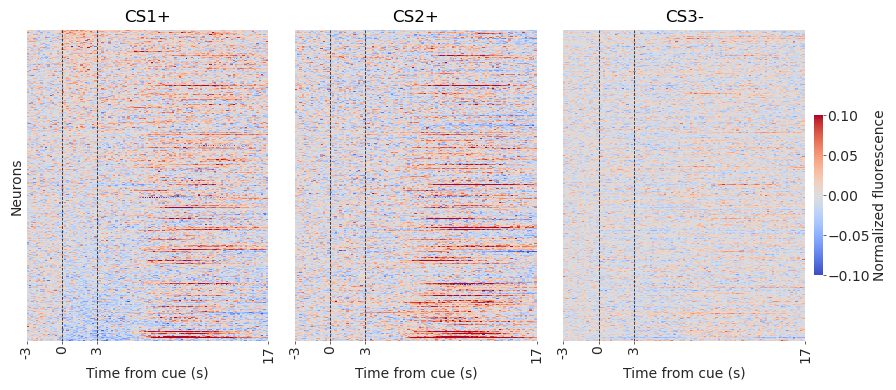

In [118]:
# Plot PSTH
import importlib
import plot_utils
importlib.reload(plot_utils)

fig_calcium_PSTH = plot_utils.plot_average_PSTH_around_interest_window(
    trial_types,
    Fcorr_around_cue,
    window_size,
    pre_window_size,
    frames_to_reward,
    sortwindow,
    framerate
)
fig_calcium_PSTH.savefig(os.path.join(result_dir, "PSTH.png"), format="png")


IndexError: invalid index to scalar variable.

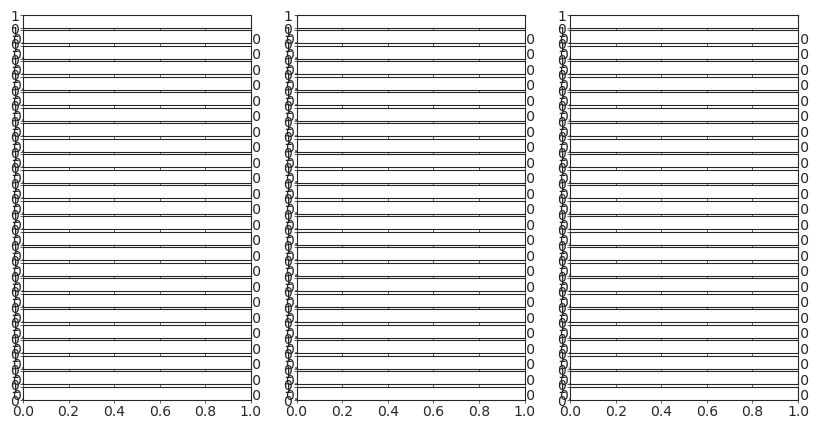

In [185]:
# Get the example cells based on sorted response, plot PSTH
sortresponse = np.argsort(np.mean(Fcorr_around_cue[:, sortwindow[0] : sortwindow[1]], axis=1))[
    ::-1]
# example_cells = list(sortresponse[:200]) + list(sortresponse[-200:])
# F_example_cells = Fcorr_around_cue[example_cells, :]
# fig_calcium_PSTH_example_cells = plot_average_PSTH_around_interest_window(
#     trial_types,
#     F_example_cells,
#     window_size,
#     pre_window_size,
#     frames_to_reward,
#     sortwindow,
#     framerate,
# )
# fig_calcium_PSTH_example_cells.savefig(
#     os.path.join(result_dir, "PSTH_example_cells.png"), format="png"
# )

cells_sort_by_activity = sortresponse[0:10]
cells_to_plot = cells_sort_by_activity[0:int(np.floor(1*len(cells_sort_by_activity)))]
plot_individual_cells_activity(Fcorr_around_cue, allCS, im_idx_around_cue, cells_to_plot, num_planes, result_dir)

In [189]:
cells_per_plane = [[] for _ in range(num_planes)]
for cell in cells_to_plot:
    if cell < len(Fcorr_around_cue[0]):
        cells_per_plane[0].append(cell)
    elif (cell < (len(Fcorr_around_cue[0]) + len(Fcorr_around_cue[1]))) and (cell >= len(Fcorr_around_cue[0])):
        cell = cell - len(Fcorr_around_cue[0])
        cells_per_plane[1].append(cell)
for ip in range(num_planes):
    for cell in cells_per_plane[ip]:
        for cue_type, cs in enumerate(allCS):
            cue_ts = im_idx_around_cue[ip][cue_type]
            if cue_type == 0:
                flattened_cue_ts = [item for sublist in cue_ts for item in sublist]
                ymax = np.max(Fcorr_around_cue[ip][cell][flattened_cue_ts])
                ymin = np.min(Fcorr_around_cue[ip][cell][flattened_cue_ts])

IndexError: invalid index to scalar variable.

In [193]:
print(cells_to_plot)
cells_per_plane

[ 231  945  581  521  982  463  833 1109  778  482]


[[231], [272, 212, 154, 173], [], []]

In [194]:
np.shape(Fcorr_around_cue)

(1226, 309)